In [30]:
# !pip install gdown

In [31]:
# !gdown 1wL49U0RSJsgMfhQtyBjgbKkSo_bDjDlo

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import pickle
from keras.callbacks import EarlyStopping
from keras.losses import BinaryCrossentropy
from keras.models import load_model
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

# Classification

In [76]:
def preprocess_data(data):

  data.drop(data.columns[0], axis=1, inplace=True)

  missing_percentage = data.isnull().mean() * 100
  data = data[missing_percentage[missing_percentage <= 5].index]

  var_thr = VarianceThreshold(threshold = 0.25)
  var_thr.fit(data.drop(columns=['Month', 'class']))
  low_var = [column for column in data.drop(columns=['Month', 'class']).columns if column not in data.drop(columns=['Month', 'class']).columns[var_thr.get_support()]]
  data.drop(low_var,axis=1, inplace=True)

  columns = data.columns

  data['Month.Category'] = data['Month'].str[-2:].astype(int)
  data.drop('Month', axis=1, inplace=True)

  category_columns = [col for col in data.columns if 'Category' in col]

  encoded_dfs = []

  for col in category_columns:
      if col != 'class':
        freq_encoding = data.groupby(col).size() / len(data)
        data[col + '_freq_encoded'] = data[col].map(freq_encoding)

  data.drop(columns=category_columns, inplace=True)

  columns_with_nan = data.columns[data.isna().any()].tolist()

  for col in columns_with_nan:
      col_mean = data[col].mean()
      data[col].fillna(col_mean, inplace=True)

  return data, columns

def preprocess_input(data):

  data['Month.Category'] = data['Month'].str[-2:].astype(int)
  data.drop('Month', axis=1, inplace=True)

  category_columns = [col for col in data.columns if 'Category' in col]

  encoded_dfs = []

  for col in category_columns:
      if col != 'class':
        freq_encoding = data.groupby(col).size() / len(data)
        data[col + '_freq_encoded'] = data[col].map(freq_encoding)

  data.drop(columns=category_columns, inplace=True)

  columns_with_nan = data.columns[data.isna().any()].tolist()

  for col in columns_with_nan:
      col_mean = data[col].mean()
      data[col].fillna(col_mean, inplace=True)

  return data

def build_model(input_dim):

  model = Sequential()
  model.add(Dense(25, activation="relu", input_dim=(input_dim)))
  model.add(Dense(20, activation="relu"))
  model.add(Dense(15, activation="relu"))
  model.add(Dense(10, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  return model

def train(model, data):
  x_train, x_val, y_train, y_val = train_test_split(data.drop(columns=['class']), data[['class']], test_size=0.2, random_state=1, shuffle=True)

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

  history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=150, validation_data=(x_val, y_val), callbacks=[early_stopping])

  return model, history

def display_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

<ipython-input-76-749144d019d8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(low_var,axis=1, inplace=True)
<ipython-input-76-749144d019d8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month.Category'] = data['Month'].str[-2:].astype(int)
<ipython-input-76-749144d019d8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Month', axis=1, inplace=T

Epoch 1/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7436 - loss: 0.5591 - val_accuracy: 0.8566 - val_loss: 0.3433
Epoch 2/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8896 - loss: 0.2796 - val_accuracy: 0.9425 - val_loss: 0.2006
Epoch 3/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1091 - val_accuracy: 0.9826 - val_loss: 0.0612
Epoch 4/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9827 - loss: 0.0514 - val_accuracy: 0.9921 - val_loss: 0.0290
Epoch 5/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0280 - val_accuracy: 0.9902 - val_loss: 0.0198
Epoch 6/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0163 - val_accuracy: 0.9968 - val_loss: 0.0135
Epoch 7/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0066 - val_accuracy: 0.9975 - val_loss: 0.0101
Epoch 8/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0043 - val_acc

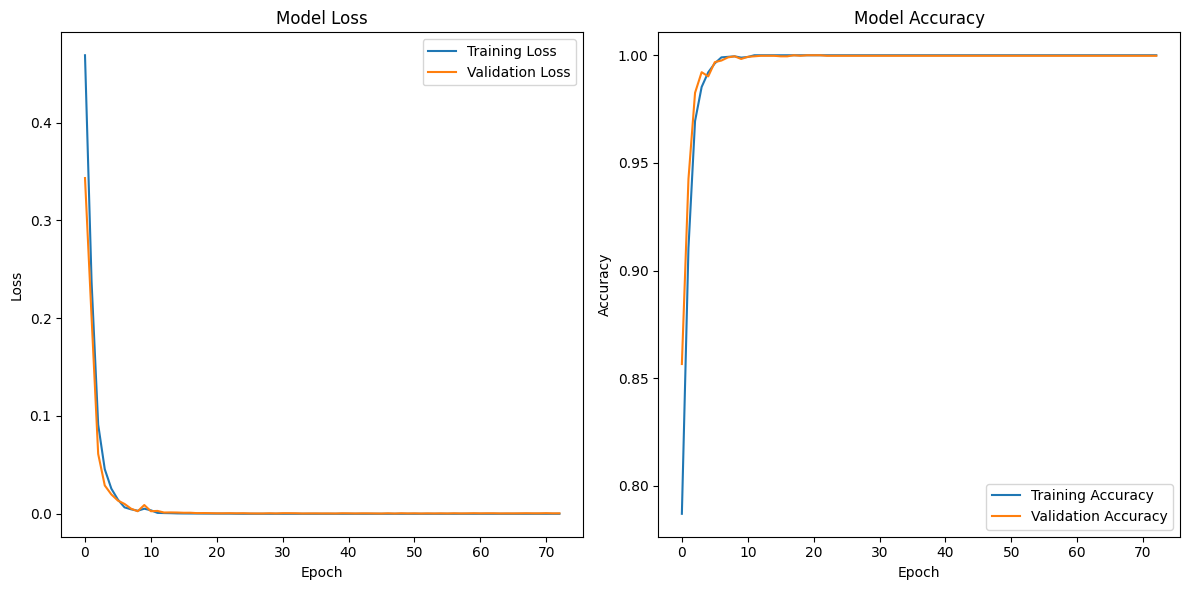


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
AUROC: 1.0
Gini Score: 1.0


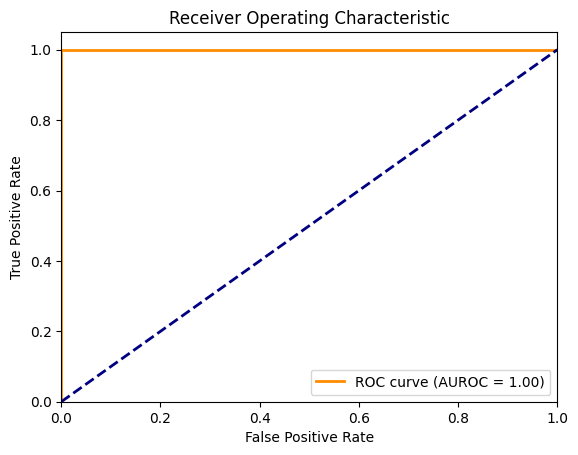

Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3633
           1   1.000000  1.000000  1.000000      1459

    accuracy                       1.000000      5092
   macro avg   1.000000  1.000000  1.000000      5092
weighted avg   1.000000  1.000000  1.000000      5092



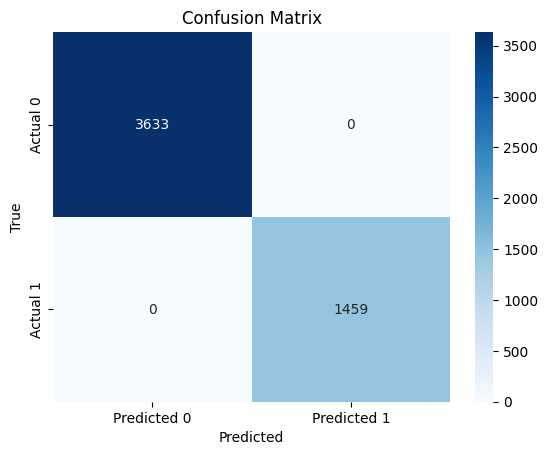

In [77]:
def run(csv):
  input_data = pd.read_csv(csv)
  train_data, test_data = train_test_split(input_data, test_size=0.2, random_state=1)

  train_data, columns = preprocess_data(train_data)

  test_data = preprocess_input(test_data[columns])

  input_dim = train_data.shape[1]-1
  model, history = train(build_model(input_dim), train_data)

  print('')
  print(history.history['val_loss'][-1])
  print(history.history['val_accuracy'][-1])
  display_history(history)
  print('')

  y_pred = model.predict(test_data.drop(columns='class'))
  y_true = test_data['class'].astype(int)
  y_pred_binary = (y_pred > 0.5).astype(int)

  fpr, tpr, _ = roc_curve(y_true, y_pred_binary)
  roc_auc = auc(fpr, tpr)

  auroc = roc_auc_score(y_true, y_pred_binary)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUROC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')

  gini_coefficient = 2 * auroc - 1
  print("AUROC:", auroc)
  print("Gini Score:", gini_coefficient)

  plt.show()

  cm = confusion_matrix(y_true, y_pred_binary)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

  print("Classification Report:")
  print(classification_report(y_true, y_pred_binary, digits=6))

  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  with open("model.pkl", "wb") as file:
      pickle.dump(model, file)

  with open("prediction.txt", "w") as file:
      file.write("Predicted labels (binary):\n")
      np.savetxt(file, y_pred_binary, fmt='%d')

if __name__ == "__main__":
  run('lending_sample.csv') #disesuaikan dengan nama/direktori file

# Model Diagnostic

In [78]:
# !pip install lime

In [79]:
# !pip install scikeras

In [80]:
# !pip install shap

In [81]:
from lime import lime_tabular
from scikeras.wrappers import KerasClassifier
import shap

In [82]:
input_data = pd.read_csv('lending_sample.csv')

train_data, test_data = train_test_split(input_data, test_size=0.2, random_state=1)

train_data, columns = preprocess_data(train_data)

test_data = preprocess_input(test_data[columns])

<ipython-input-76-749144d019d8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(low_var,axis=1, inplace=True)
<ipython-input-76-749144d019d8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month.Category'] = data['Month'].str[-2:].astype(int)
<ipython-input-76-749144d019d8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Month', axis=1, inplace=T

In [83]:
with open('model.pkl', 'rb') as file:
  model = pickle.load(file)

def keras_predict(X):
  return model.predict(X).ravel()

In [84]:
train_data, val_data, train_target, val_target = train_test_split(train_data.drop(columns=['class']), train_data['class'], test_size=0.2, random_state=1, shuffle=True)

In [85]:
def plot_corr(top_list, name, scope):
  plt.figure(figsize=(8, 6))
  top_list.plot(kind='bar', color='skyblue')
  plt.title('Top 10 Features Correlated with the Target Label for {0} data'.format(name))
  plt.xlabel('{0} Feature'.format(scope))
  plt.ylabel('Correlation')
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

In [86]:
correlations = train_data.corrwith(train_target)

sorted_correlations = correlations.abs().sort_values(ascending=False)

top_10_correlated_features_training_all = sorted_correlations.head(10)
print("Top 10 features correlated with the target label:")
print(top_10_correlated_features_training_all)

Top 10 features correlated with the target label:
Numeric.133    0.807839
Numeric.145    0.607771
Numeric.144    0.569521
Numeric.151    0.518014
Numeric.150    0.468262
Numeric.126    0.379637
Numeric.143    0.362912
Numeric.142    0.345395
Numeric.149    0.318853
Numeric.148    0.301621
dtype: float64


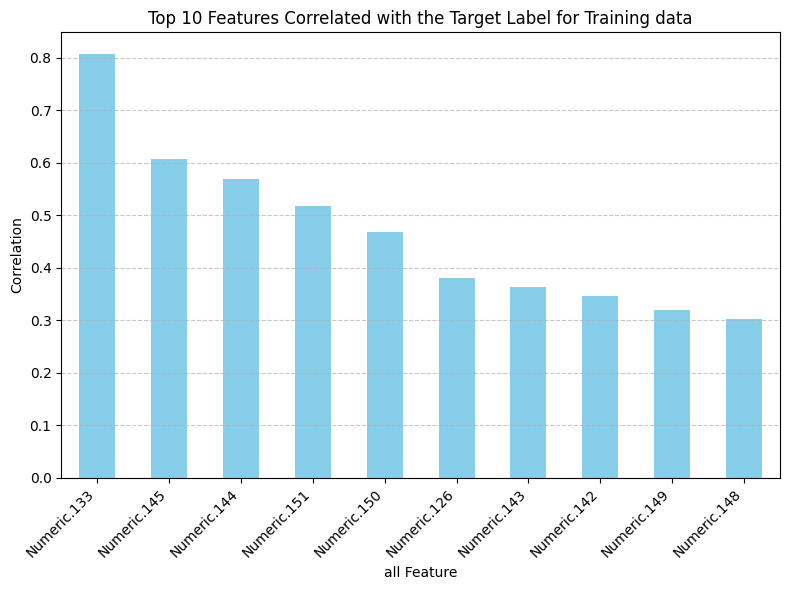

In [87]:
plot_corr(top_10_correlated_features_training_all, 'Training', 'all')

In [88]:
correlations = train_data.loc[:, train_data.columns.str.contains('Category.')].corrwith(train_target)

sorted_correlations = correlations.abs().sort_values(ascending=False)

top_10_correlated_features_training_category = sorted_correlations.head(10)
print("Top 10 features correlated with the target label:")
print(top_10_correlated_features_training_category)

Top 10 features correlated with the target label:
Category.27_freq_encoded    0.120196
Category.36_freq_encoded    0.091675
Category.38_freq_encoded    0.058924
Category.35_freq_encoded    0.058359
Category.22_freq_encoded    0.055162
Category.25_freq_encoded    0.051258
Category.19_freq_encoded    0.044907
Category.18_freq_encoded    0.042581
Category.20_freq_encoded    0.039071
Category.29_freq_encoded    0.038321
dtype: float64


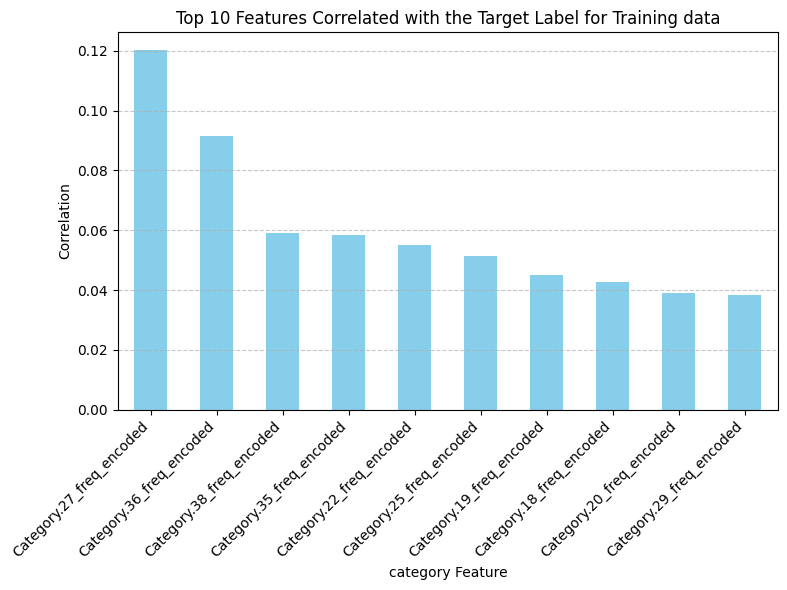

In [89]:
plot_corr(top_10_correlated_features_training_category, 'Training', 'category')

In [90]:
correlations = val_data.corrwith(val_target)

sorted_correlations = correlations.abs().sort_values(ascending=False)

top_10_correlated_features_val_all = sorted_correlations.head(10)
print("Top 10 features correlated with the target label:")
print(top_10_correlated_features_val_all)

Top 10 features correlated with the target label:
Numeric.133    0.812134
Numeric.145    0.608625
Numeric.144    0.571405
Numeric.151    0.515696
Numeric.150    0.463302
Numeric.126    0.373576
Numeric.143    0.354321
Numeric.142    0.339496
Numeric.149    0.309727
Numeric.148    0.292514
dtype: float64


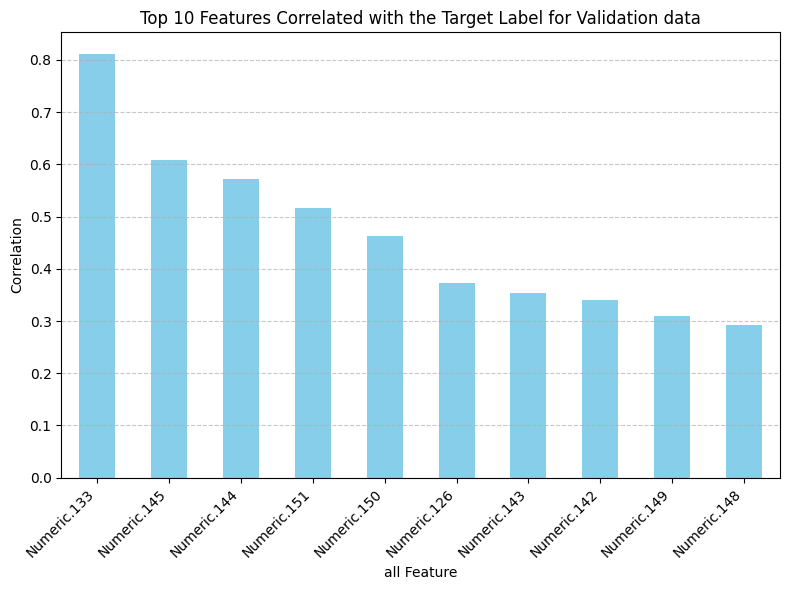

In [91]:
plot_corr(top_10_correlated_features_val_all, 'Validation', 'all')

In [92]:
correlations = val_data.loc[:, train_data.columns.str.contains('Category.')].corrwith(val_target)

sorted_correlations = correlations.abs().sort_values(ascending=False)

top_10_correlated_features_val_category = sorted_correlations.head(10)
print("Top 10 features correlated with the target label:")
print(top_10_correlated_features_val_category)

Top 10 features correlated with the target label:
Category.27_freq_encoded    0.145861
Category.36_freq_encoded    0.102786
Category.29_freq_encoded    0.083500
Category.25_freq_encoded    0.068615
Category.35_freq_encoded    0.066757
Category.4_freq_encoded     0.047077
Category.19_freq_encoded    0.044189
Category.14_freq_encoded    0.043118
Category.26_freq_encoded    0.040198
Category.22_freq_encoded    0.040058
dtype: float64


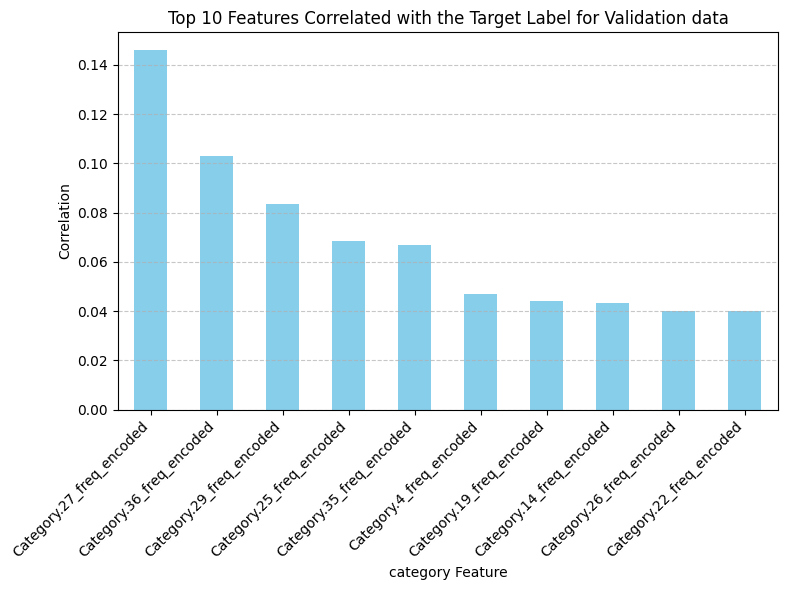

In [93]:
plot_corr(top_10_correlated_features_val_category, 'Validation', 'category')

In [94]:
correlations = test_data.drop(columns='class').corrwith(test_data['class'])

sorted_correlations = correlations.abs().sort_values(ascending=False)

top_10_correlated_features_test_all = sorted_correlations.head(10)
print("Top 10 features correlated with the target label:")
print(top_10_correlated_features_test_all)

Top 10 features correlated with the target label:
Numeric.133    0.821711
Numeric.145    0.597798
Numeric.144    0.560539
Numeric.151    0.511889
Numeric.150    0.459696
Numeric.126    0.372330
Numeric.143    0.352959
Numeric.142    0.339306
Numeric.149    0.311444
Numeric.148    0.294670
dtype: float64


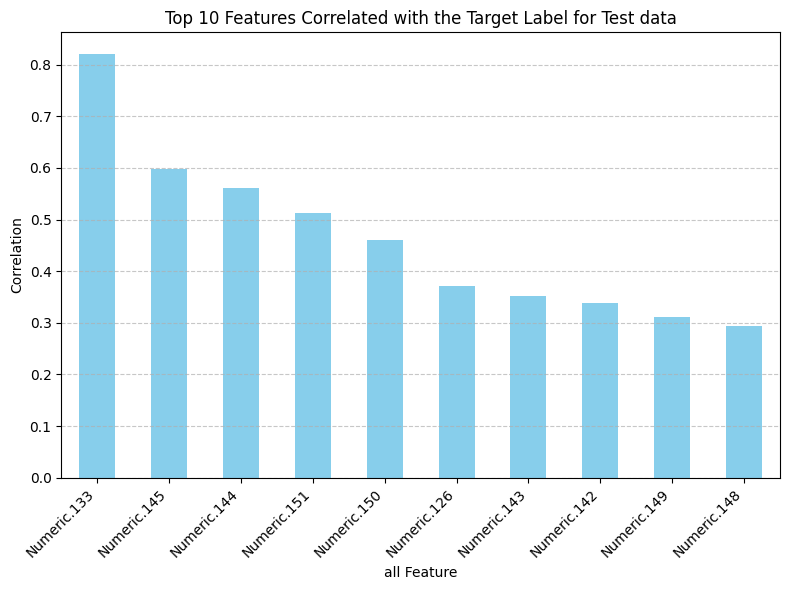

In [95]:
plot_corr(top_10_correlated_features_test_all, 'Test', 'all')

In [96]:
correlations = test_data.drop(columns='class').loc[:, train_data.columns.str.contains('Category.')].corrwith(test_data['class'])

sorted_correlations = correlations.abs().sort_values(ascending=False)

top_10_correlated_features_test_category = sorted_correlations.head(10)
print("Top 10 features correlated with the target label:")
print(top_10_correlated_features_test_category)

Top 10 features correlated with the target label:
Category.27_freq_encoded    0.134566
Category.36_freq_encoded    0.086700
Category.22_freq_encoded    0.070450
Category.38_freq_encoded    0.069365
Category.35_freq_encoded    0.065362
Category.16_freq_encoded    0.057674
Category.25_freq_encoded    0.055631
Category.26_freq_encoded    0.049402
Category.19_freq_encoded    0.046639
Category.24_freq_encoded    0.046361
dtype: float64


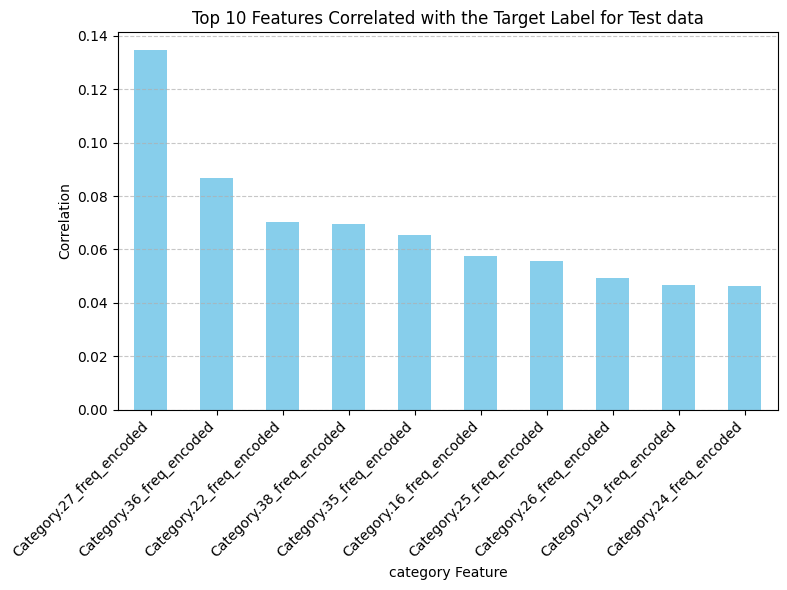

In [97]:
plot_corr(top_10_correlated_features_test_category, 'Test', 'category')

In [98]:
def build_model():

  model = Sequential()
  model.add(Dense(25, activation="relu", input_dim=(train_data.shape[1]-1)))
  model.add(Dense(20, activation="relu"))
  model.add(Dense(15, activation="relu"))
  model.add(Dense(10, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  return model

clf = KerasClassifier(build_fn=build_model, verbose=0)

In [99]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=train_data.values,
    feature_names=train_data.columns,
    class_names=['Non-Default', 'Default'],
    mode='classification'
)

In [103]:
random_samples = test_data.sample(n=10)

for i in range(3):
    exp = explainer.explain_instance(random_samples.drop(columns='class').values[i], model.predict, num_features=10, top_labels=1)
    exp.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
